In [6]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
# Aplicação do HDBSCAN
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [28]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False ) & 
                                (dados.iloc[:, 6] == True) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 9] == False)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == True) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 9] == False)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:4000]

ids_ecgs = ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 28262
Número de linhas ecg_doente_linhas: 897
Tirando Interferência:
Número de linhas ecg_normal_linhas: 27628
Número de linhas ecg_doente_linhas: 887
Número de ecgs pra clusterizar: 5000


In [35]:
# Função para obter dados de ECG de um arquivo HDF5
def get_ecg_data(file_paths, exam_id):
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) != 0:
                exam_index = exam_index[0]
                exam_tracings = f['tracings'][exam_index]
                return exam_tracings
    raise ValueError("Exam ID não encontrado em nenhum dos arquivos fornecidos.")

# Caminhos para os arquivos HDF5
file_paths = ['../Database/filtered_exams_14_15.hdf5', '../Database/filtered_exams_16_17.hdf5']

# Obter os tracings de ECG para cada exam_id e armazenar na lista
all_tracings = []
for exam_id in ids_ecgs:
    tracings = get_ecg_data(file_paths, exam_id)
    # Selecionar as leads V1 (índice 6) e V6 (índice 11)
    lead_v1 = tracings[:, 6]
    lead_v6 = tracings[:, 11]
    # Combinar as leads V1 e V6 em uma única dimensão
    combined_leads = np.concatenate((lead_v1, lead_v6))
    all_tracings.append(combined_leads)

# Converter lista para array numpy
X = np.array(all_tracings)

print("Shape de X para o autoencoder:", X.shape)

# X agora está pronto para ser usado no autoencoder

Shape de X para o autoencoder: (5000, 8192)


In [37]:
#CARREGAR MODELO

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model

# Define the encoder
def encoder_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=40, kernel_size=16, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=40, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    encoded = Conv1D(filters=1, kernel_size=16, strides=1, padding='same')(x)

    return Model(inputs, encoded, name="encoder")

# Define the decoder
def decoder_model(encoded_shape):
    inputs = Input(shape=encoded_shape)
    x = Conv1DTranspose(filters=40, kernel_size=16, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=40, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    decoded = Conv1DTranspose(filters=1, kernel_size=16, strides=2, padding='same')(x)

    return Model(inputs, decoded, name="decoder")

# Define the full autoencoder
def autoencoder_model(input_shape):
    encoder = encoder_model(input_shape)
    decoder = decoder_model(encoder.output_shape[1:])
    
    inputs = Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    
    autoencoder = Model(inputs, decoded, name="autoencoder")
    
    return autoencoder




Epoch 1/50


125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 225ms/step - loss: 0.0878 - val_loss: 0.0147
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - loss: 0.0116 - val_loss: 0.0120
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - loss: 0.0106 - val_loss: 0.0114
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 219ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 12/50
125/125 ━━━━━━━━━━

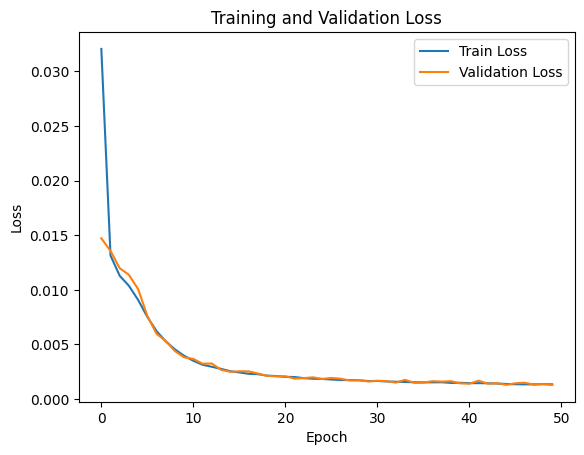

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


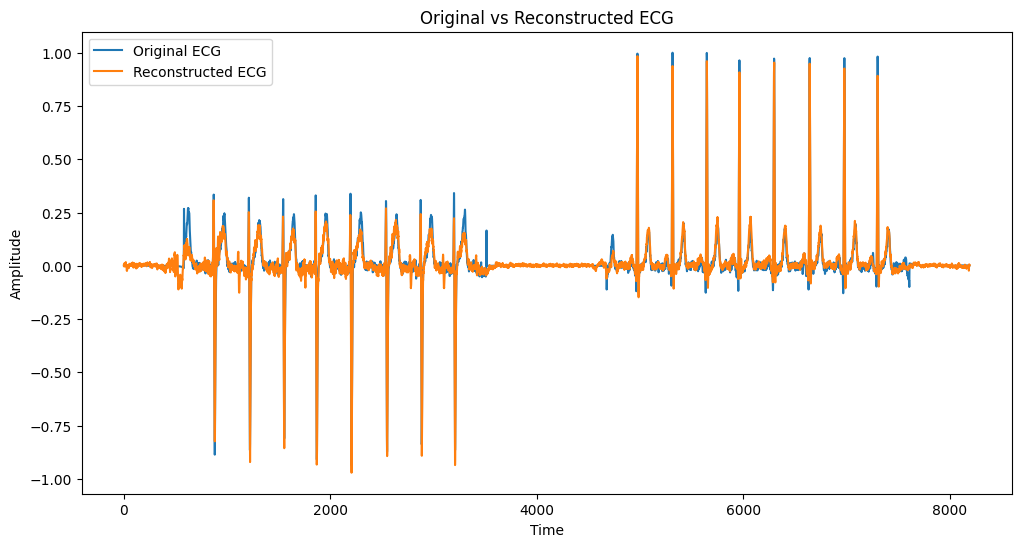

In [39]:
#EXECUTAR MODELO

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# Se ainda não estiver carregado, use np.load() ou outra forma de carregar seus dados

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Definir o autoencoder
autoencoder = autoencoder_model((8192, 1))
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinar o modelo
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), callbacks=[early_stopping])

# Plotar a perda de treino e validação
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test[idx]

# Reconstruir o ECG usando o autoencoder
reconstructed_ecg = autoencoder.predict(np.expand_dims(original_ecg, axis=0))

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()

# Salvar o modelo treinado no formato Keras
autoencoder.save('autoencoder_model_OLB.keras')

# Salvar o modelo treinado
autoencoder.save('autoencoder_model_OLB.h5')
